**Work plan:** 

**1. Overview of the datas and variables.**  
  
**2. Let's scan numeric variables using `Standard Scale()`, recode test and categorical variables using `get_dummies`.**   
   
**3. Let's select the signs using `RFECV` and cross-validation `RepeatedStratifiedKFold`.**  
  
**4. Let's train on `RandomForestClassifier`, `ExtraTreesClassifier`, `GradientBoostingClassifie`. Let's take the `recall` metric as a basis.  It is important to us that all cases of possible heart disease are predicted to minimize the `false negative`.** 
  

**Attribute Information:**  
      
**<li>`Age`**: age of the patient [years]  
      
**<li>`Sex`**: sex of the patient [M: Male, F: Female]  
      
**<li>`ChestPainType`**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]  
      
**<li>`RestingBP`**: resting blood pressure [mm Hg]  
      
**<li>`Cholesterol`**: serum cholesterol [mm/dl]  
      
**<li>`FastingBS`**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]   
      
**<li>`RestingECG`**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]  
      
**<li>`MaxHR`**: maximum heart rate achieved [Numeric value between 60 and 202]  
      
**<li>`ExerciseAngina`**: exercise-induced angina [Y: Yes, N: No]  
      
**<li>`Oldpeak`**: oldpeak = ST [Numeric value measured in depression]  
      
**<li>`ST_Slope`**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]  
      
**<li>`HeartDisease`**: output class [1: heart disease, 0: Normal]

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use("Solarize_Light2")

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-prediction/heart.csv


# Data overview

In [3]:
data = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

In [4]:
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [5]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
data.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

**We form variables by category for further processing**

In [8]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorial = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target = ['HeartDisease']
text = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

**Visualize the variables with each other using pairplot**

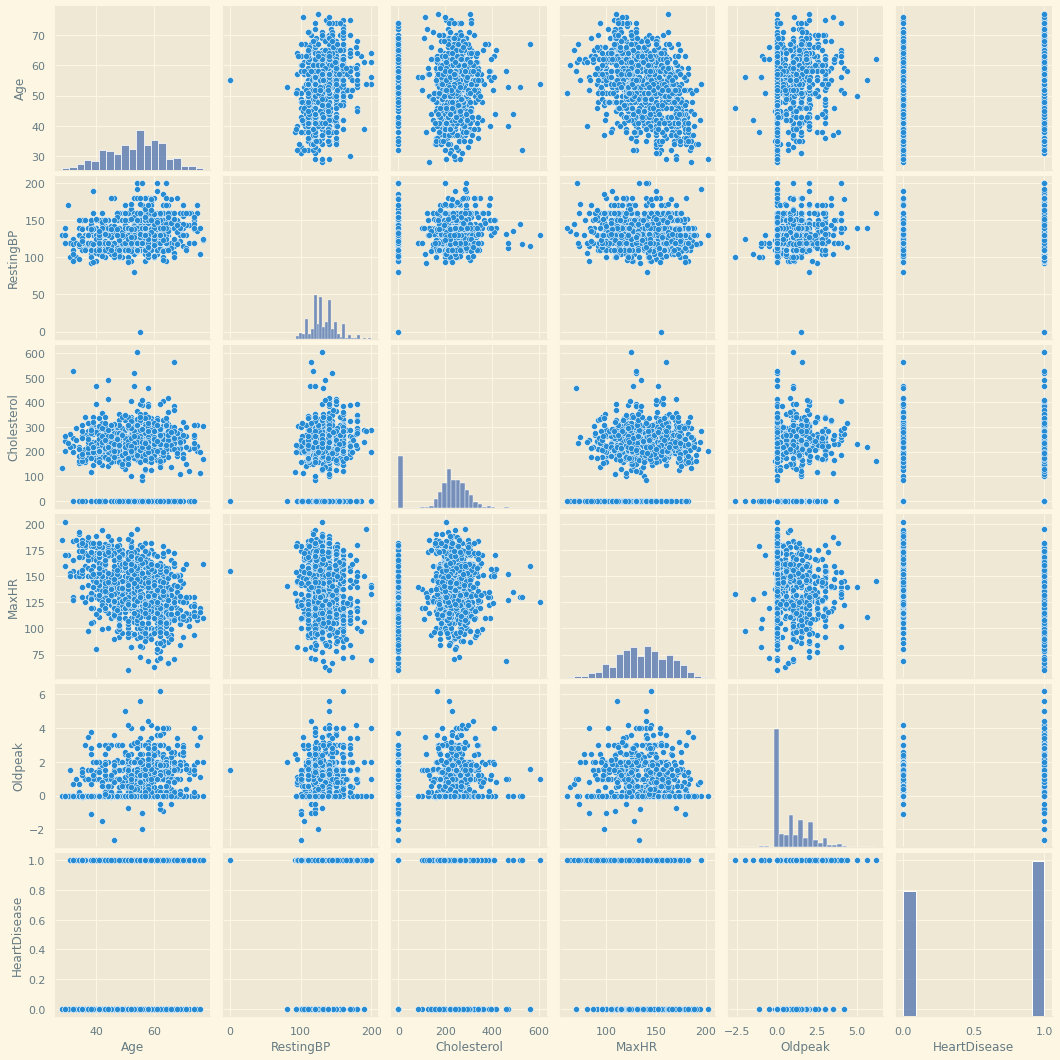

In [10]:
sns.pairplot(data[numerical + target])

**Plotting density graphs and boxplots**

In [11]:
data_labenc = data.copy()
labelencoder = LabelEncoder()
for i in text:
    data_labenc[i] = labelencoder.fit_transform(data_labenc[i])

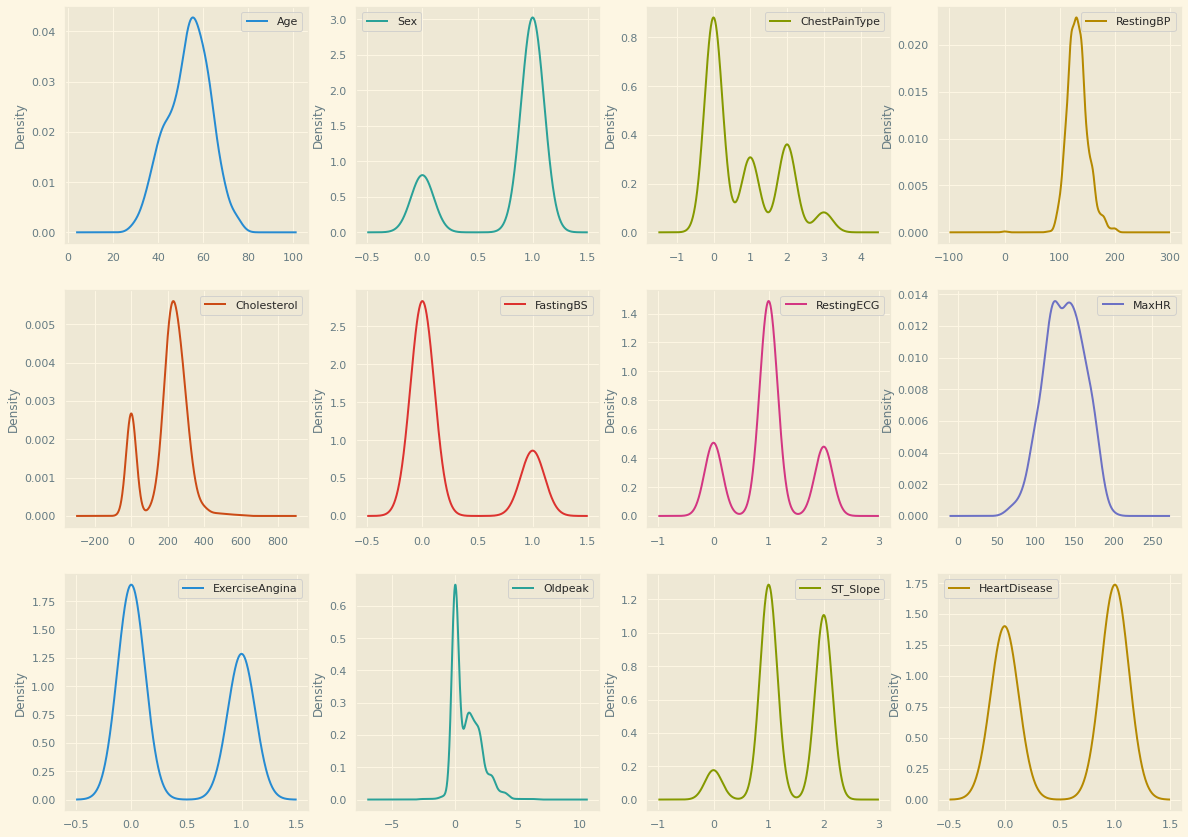

In [12]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
data_labenc.plot(kind='density', subplots=True, layout=(4, 4), sharex=False, ax=ax)
plt.show()

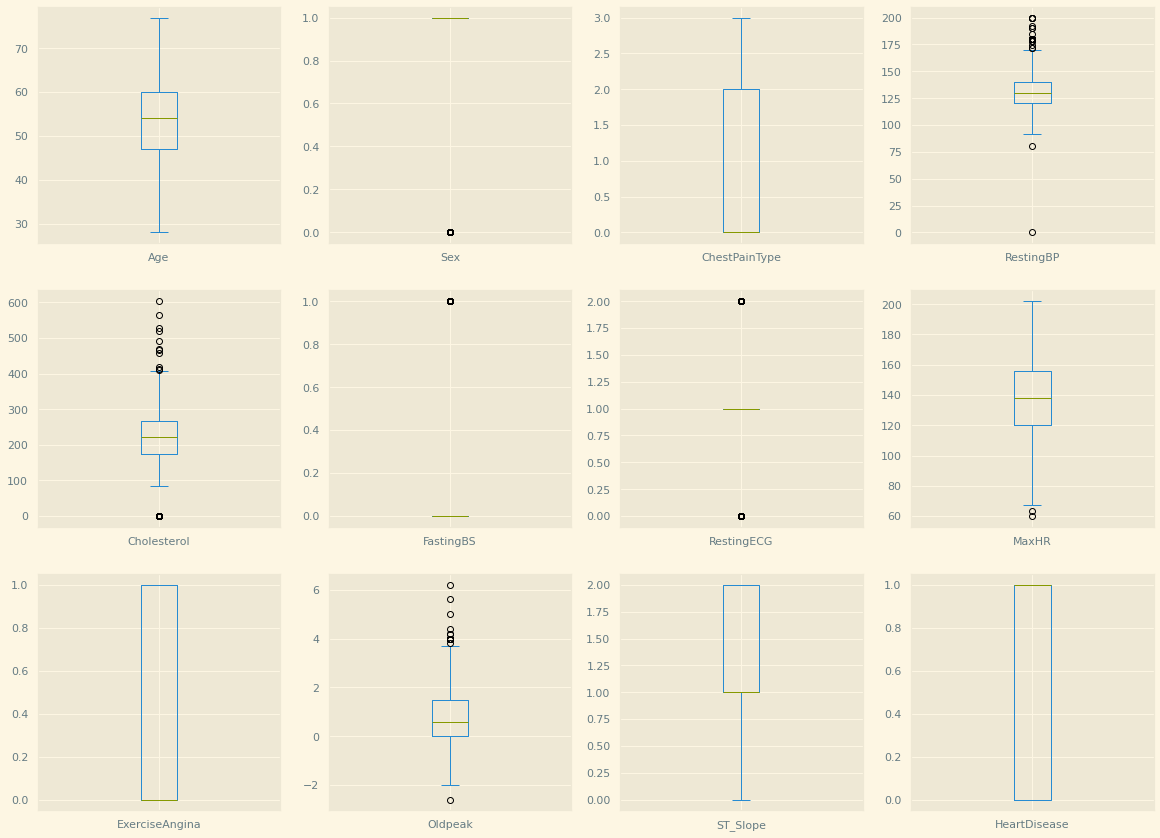

In [13]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
data_labenc.plot(kind='box', subplots=True, layout=(4, 4), sharex=False, ax=ax)
plt.show()

**Let's encode our variables to build a histogram with the target variable - `Heart Disease`**

In [14]:
cat_labelencoder = ['Sex', 'ExerciseAngina']
for i in cat_labelencoder:
    data[i] = labelencoder.fit_transform(data[i])

In [15]:
cat_get_dummies = ['ChestPainType', 'RestingECG', 'ST_Slope']

data = pd.get_dummies(data, columns=cat_get_dummies)

In [16]:
data.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

array([[<AxesSubplot:title={'center':'(Age, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(Sex, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(RestingBP, mean)'}, xlabel='HeartDisease'>],
       [<AxesSubplot:title={'center':'(Cholesterol, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(FastingBS, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(MaxHR, mean)'}, xlabel='HeartDisease'>],
       [<AxesSubplot:title={'center':'(ExerciseAngina, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(Oldpeak, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(ChestPainType_ASY, mean)'}, xlabel='HeartDisease'>],
       [<AxesSubplot:title={'center':'(ChestPainType_ATA, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(ChestPainType_NAP, mean)'}, xlabel='HeartDisease'>,
        <AxesSubplot:title={'center':'(ChestPainType_TA, mean)'}, xlabe

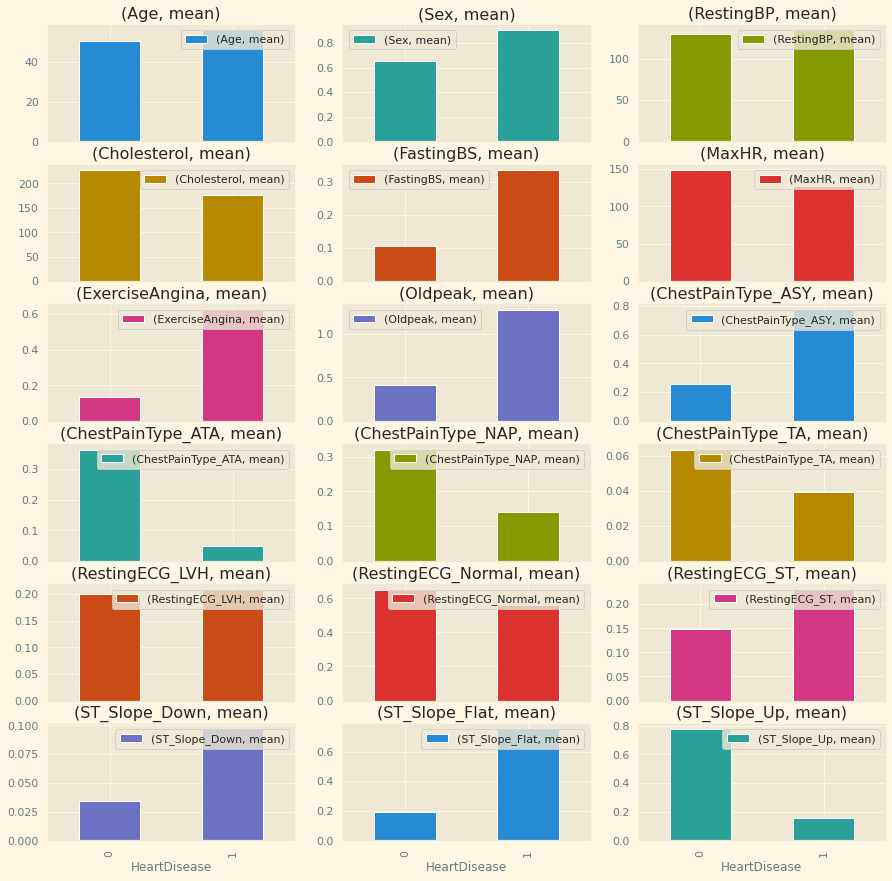

In [17]:
data.groupby(target)[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up']]\
.agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(6, 3))

**The histogram clearly shows which signs affect the presence of heart disease (`Heart Disease` == 1)**

# Split and Scaler

In [18]:
X = data.drop(target, axis=1)
y = data[target]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
scaler = StandardScaler()

x_train_scaler = scaler.fit_transform(x_train[numerical])
x_test_scaler = scaler.transform(x_test[numerical])

x_train[numerical] = x_train_scaler
x_test[numerical] = x_test_scaler

In [21]:
x_train_scaler

array([[ 0.46471433, -1.77231378,  0.2949892 ,  0.77460871, -0.7294597 ],
       [ 0.78176703, -1.23486848, -1.90539005, -1.17367255,  0.99028313],
       [-0.06370685,  1.45235803, -1.90539005, -0.60542385, -0.81997248],
       ...,
       [ 0.6760828 , -0.15997788,  0.47365248,  0.28753839,  0.44720645],
       [ 0.6760828 ,  1.02240179, -1.90539005, -0.76778062, -0.81997248],
       [-1.43760192,  0.91491273,  1.78071537, -0.28071031,  0.99028313]])

# Feature selection (feature ranking)

**In order not to 'feed' our algorithm 18 features, we will select the most important ones among them using recursive `RFECV` exclusion and `RepeatedStratifiedKFold` cross-validation.**

**Creating an instance of the `RFECV` class specifying the `Gradient Boosting Classifier` evaluator**

In [22]:
rfecv = RFECV(estimator=GradientBoostingClassifier())

**Creating an instance of the model that we will use**

In [23]:
model = GradientBoostingClassifier()

**Defining `pipeline` and `cv`**

In [24]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
n_scores = cross_val_score(pipeline, x_train, y_train.values.ravel(), scoring='recall', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.8801848739495799

**We apply the pipeline and get the optimal number of veribles.**

In [25]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [26]:
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 13


**Estimates during cross-validation**

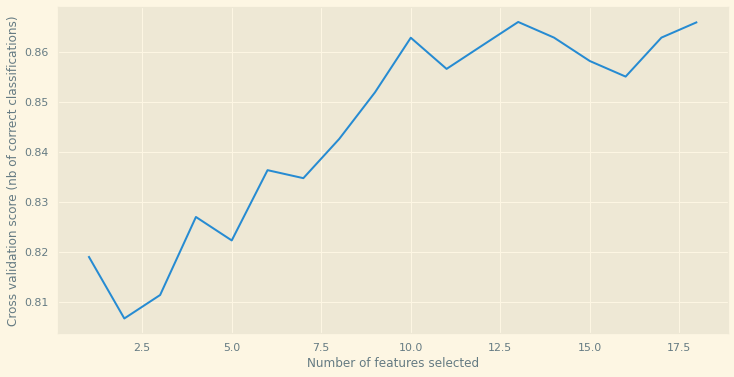

In [27]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [28]:
pd.DataFrame(rfecv.support_,index=X.columns,columns=['Rank'])

,Rank
Age,True
Sex,True
RestingBP,True
Cholesterol,True
FastingBS,True
MaxHR,True
ExerciseAngina,True
Oldpeak,True
ChestPainType_ASY,True
ChestPainType_ATA,False


**Getting the list `True`**

In [29]:
data_rfecv = pd.DataFrame(rfecv.support_,index=X.columns,columns=['Rank'])
data_rfecv[data_rfecv.Rank == True].index.unique()

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'RestingECG_LVH',
       'RestingECG_Normal', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [30]:
col_rfecv = data_rfecv[data_rfecv.Rank == True].index.unique()

**Correcting x_test and x_train**

In [31]:
x_test = x_test[col_rfecv]
x_train = x_train[col_rfecv]

# RandomForestClassifier

**Setting the functions**

In [32]:
def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}\nRoc_auc: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction),
        roc_auc_score(actual, prediction)))

In [33]:
def plot_features(clf):
    feature_importances = clf.feature_importances_
    pd.DataFrame({'features': x_train.columns,
                                           'feature_importances': feature_importances})\
    .sort_values('feature_importances', ascending=False).plot.barh(x ='features', figsize=(10, 7))

In [34]:
def data_features(clf):
    feature_importances = clf.feature_importances_
    return pd.DataFrame({'features': x_train.columns,
                                           'feature_importances': feature_importances})\
    .sort_values('feature_importances', ascending=False)
    

In [35]:
def con_matrix(actual, prediction):
    tn, fp, fn, tp = confusion_matrix(actual, prediction).ravel()
    print('*True Positive', tp, ' - patients who were correctly diagnosed with heart disease!')
    print('False Negative', fn, ' - patients who did not have heart disease, but were identified as sick')
    print('True Negative', tn, ' - patients who did not have heart disease and were identified as healthy')
    print('*False Positive', fp, ' - patients who had heart disease, but were identified as healthy!')

**Training the model**

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

rnd_clf.fit(x_train, y_train)

predict_rnd = rnd_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_rnd)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_rnd)


Test quality: 

Accuracy: 0.873
Precision: 0.896
Recall: 0.890
f1_score: 0.893
Roc_auc: 0.869

The confusion matrix : 

*True Positive 146  - patients who were correctly diagnosed with heart disease!
False Negative 18  - patients who did not have heart disease, but were identified as sick
True Negative 95  - patients who did not have heart disease and were identified as healthy
*False Positive 17  - patients who had heart disease, but were identified as healthy!


In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, predict_rnd).ravel()

In [38]:
confusion_matrix(y_test, predict_rnd)[1][1]

146

**The importance of features in our training**

In [39]:
data_features(rnd_clf)

,features,feature_importances
12,ST_Slope_Up,0.222919
11,ST_Slope_Flat,0.177285
6,ExerciseAngina,0.119061
7,Oldpeak,0.117076
8,ChestPainType_ASY,0.107788
5,MaxHR,0.063781
3,Cholesterol,0.057905
0,Age,0.053574
2,RestingBP,0.028456
1,Sex,0.027105


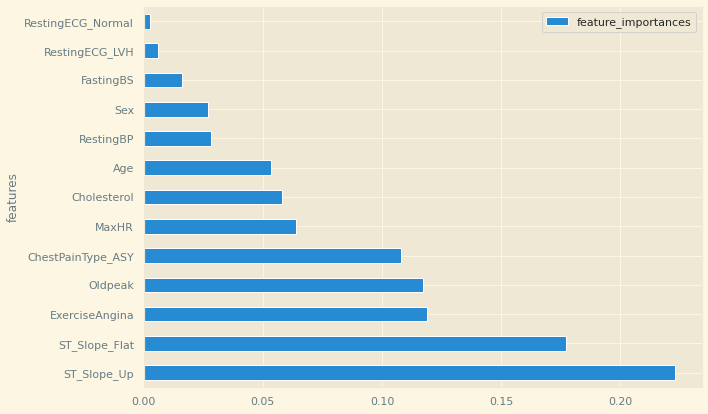

In [40]:
plot_features(rnd_clf)

# ExtraTreesClassifier

**We repeat our actions**

In [41]:
ex_clf = ExtraTreesClassifier(n_estimators=400, max_leaf_nodes=14, n_jobs=-1,  random_state=42)

ex_clf.fit(x_train, y_train)

predict_ex = ex_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_ex)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_ex)


Test quality: 

Accuracy: 0.888
Precision: 0.918
Recall: 0.890
f1_score: 0.904
Roc_auc: 0.887

The confusion matrix : 

*True Positive 146  - patients who were correctly diagnosed with heart disease!
False Negative 18  - patients who did not have heart disease, but were identified as sick
True Negative 99  - patients who did not have heart disease and were identified as healthy
*False Positive 13  - patients who had heart disease, but were identified as healthy!


**The importance of features in our training**

In [42]:
data_features(ex_clf)

,features,feature_importances
12,ST_Slope_Up,0.312664
11,ST_Slope_Flat,0.224960
6,ExerciseAngina,0.156756
8,ChestPainType_ASY,0.125657
1,Sex,0.044890
7,Oldpeak,0.036169
3,Cholesterol,0.028177
4,FastingBS,0.025920
5,MaxHR,0.018689
0,Age,0.013057


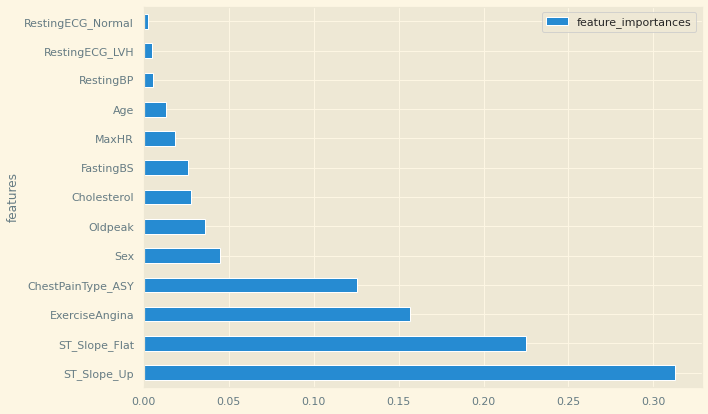

In [43]:
plot_features(ex_clf)

# GradientBoostingClassifier

**We repeat our actions**

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gdc_clf = GradientBoostingClassifier(n_estimators=400, max_features=2, max_depth = 2, random_state = 42) 

gdc_clf.fit(x_train, y_train)

predict_gbc = gdc_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_gbc)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_gbc)


Test quality: 

Accuracy: 0.884
Precision: 0.929
Recall: 0.872
f1_score: 0.899
Roc_auc: 0.887

The confusion matrix : 

*True Positive 143  - patients who were correctly diagnosed with heart disease!
False Negative 21  - patients who did not have heart disease, but were identified as sick
True Negative 101  - patients who did not have heart disease and were identified as healthy
*False Positive 11  - patients who had heart disease, but were identified as healthy!


**The importance of features in our training**

In [45]:
data_features(gdc_clf)

,features,feature_importances
12,ST_Slope_Up,0.186244
11,ST_Slope_Flat,0.169214
7,Oldpeak,0.161736
6,ExerciseAngina,0.095331
8,ChestPainType_ASY,0.088325
5,MaxHR,0.076627
3,Cholesterol,0.056795
0,Age,0.050688
1,Sex,0.046409
2,RestingBP,0.031354


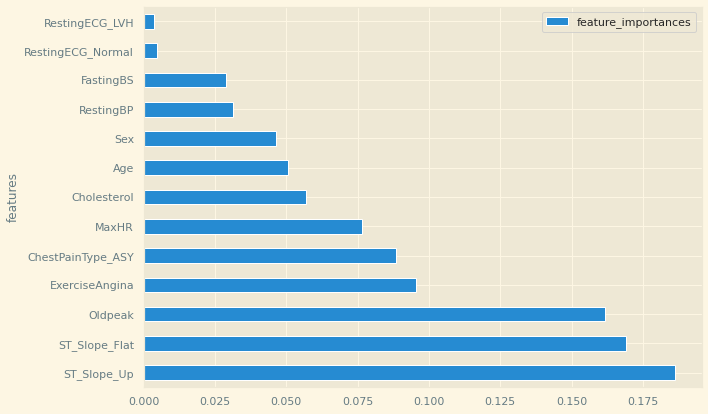

In [46]:
plot_features(gdc_clf)

# ROC Curves and AUC

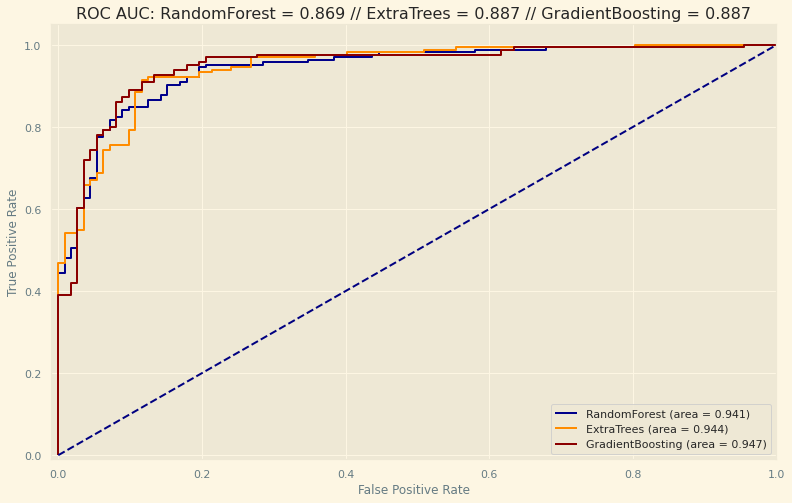

In [47]:
y_predicted_prob_rnd = rnd_clf.predict_proba(x_test)
y_predicted_prob_ex = ex_clf.predict_proba(x_test)
y_predicted_prob_gdc = gdc_clf.predict_proba(x_test)

fpr_rnd, tpr_rnd, thresholds_rnd = roc_curve(y_test, y_predicted_prob_rnd[:,1])
fpr_ex, tpr_ex, thresholds_ex = roc_curve(y_test, y_predicted_prob_ex[:,1])
fpr_gdc, tpr_gdc, thresholds_gdc = roc_curve(y_test, y_predicted_prob_gdc[:,1])

plt.figure(figsize=(13,8))
plt.plot(fpr_rnd, tpr_rnd, color='darkblue', label='RandomForest (area = %0.3f)' % auc(fpr_rnd, tpr_rnd))
plt.plot(fpr_ex, tpr_ex, color='darkorange', label='ExtraTrees (area = %0.3f)' % auc(fpr_ex, tpr_ex))
plt.plot(fpr_gdc, tpr_gdc, color='darkred', label='GradientBoosting (area = %0.3f)' % auc(fpr_gdc, tpr_gdc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC AUC: RandomForest = {:.3f} // ExtraTrees = {:.3f} // GradientBoosting = {:.3f}'\
          .format(roc_auc_score(y_test, predict_rnd),
                  roc_auc_score(y_test, predict_ex),
                  roc_auc_score(y_test, predict_gbc)))
plt.legend(loc="lower right", title_fontsize='xx-large')

plt.show()